### 1 . Preparation
In this section, packages will be imported and the random seed will be set.


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
rs = 290310
np.random.seed(rs)

### 2. Loading and Preparing the Data
In this section, the data will be loaded into the project and will be manipulated into a manageble format for our analysis

In [81]:
df_path = 'data\cla4lsp22_bikez_curated.csv'
df_tot = pd.read_csv(df_path)


In [82]:
r = np.random.randint(0,3)
workdf = df_tot.loc[df_tot['Year']%3 == r]

In [83]:
feature_to_remove = ['Front brakes',
                     'Rear brakes', 
                     'Front tire',
                     'Rear tire',
                     'Front suspension',
                     'Rear suspension']

feature_to_remove = np.random.choice(feature_to_remove, 
                                     size=2,
                                     replace = False)
workdf = workdf.drop(columns = feature_to_remove)

print('Columns', feature_to_remove, 'have been dropped from the DataFrame')



Columns ['Rear tire' 'Front suspension'] have been dropped from the DataFrame


#### Missing values handling
Andiamo a vedere se i missing values nelle colonne categoriche hanno una particolare label:

In [84]:
categorical_columns = dict()
for col in workdf.iloc[:, 5:].columns: #for each feature (hence we exclude labels)
    if workdf[col].dtype == 'O': #if that feature is categorical
        categorical_columns[col] = workdf[col].unique() #append its unique values into a dict entry

From a visual inspection missing categorical values are labeled as "Not Given/Unknown" (N.B. could also be written in lowercase "not given/unknown")

Let's now inspect how many rows have missing values and how many missing values are there for each row.

Text(0.5, 1.0, 'Pieplot of missing values')

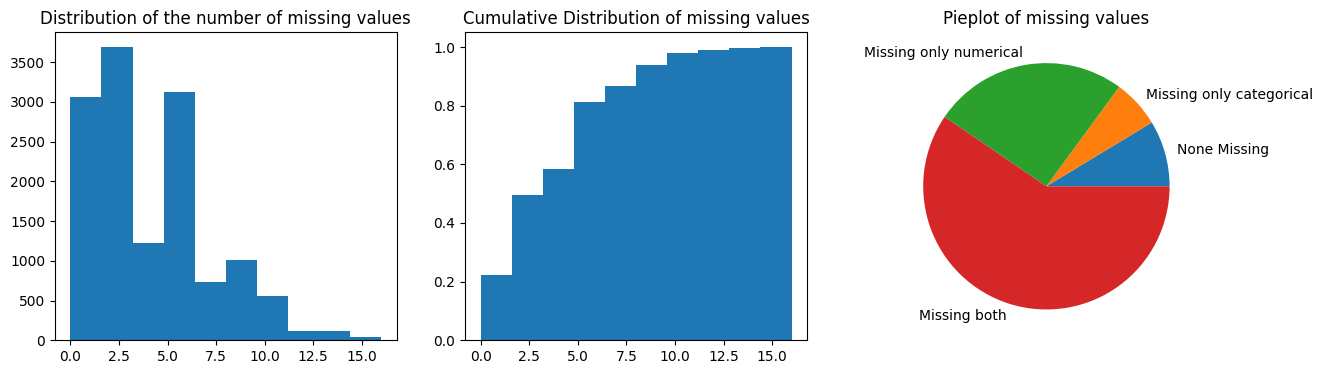

In [85]:
missing_categorical = np.zeros(len(workdf)) #array containing for each row the number of missing categorical attributes 
missing_numerical = np.zeros(len(workdf)) #array containing for each row the number of missing numerical attributes
missing_count = dict()
for col in workdf.iloc[:, 5:].columns: #for each feature (hence we exclude labels)

    if workdf[col].dtype == 'O': #if that feature is categorical
        tmp01 = (workdf[col].str.lower()=='not given/unknown')# array indicating if the value of the column is missing
        workdf.loc[tmp01, col] = np.nan #setting missing values as NaN
        tmp01 = tmp01.astype(int)
        missing_categorical = missing_categorical + tmp01
        missing_count[col] = sum(tmp01)
    else:
        tmp01 = workdf[col].isna().astype(int)
        missing_numerical = missing_numerical + tmp01
        missing_count[col] = sum(tmp01)


#  ------- Histogram and Pieplot -------

missing = missing_categorical + missing_numerical #array containing for each row the number of missing attributes

pie_label = ['None Missing', 'Missing only categorical', 'Missing only numerical', 'Missing both']
missing_categorical_bool = missing_categorical.astype(bool) #True if row contains at least one missing categorical value
missing_numerical_bool = missing_numerical.astype(bool) #True if row contains at least one missing numerical value

none_missing = np.logical_and(np.logical_not(missing_numerical_bool), np.logical_not(missing_categorical_bool)) #True if row contais all numerical and categorical values
missing_only_categorical = np.logical_and(missing_categorical_bool, np.logical_not(missing_numerical_bool)) #True if row misses only categorical data
missing_only_numerical = np.logical_and(missing_numerical_bool, np.logical_not(missing_categorical_bool)) #True if row misses only numerical data
missing_both = np.logical_and(missing_categorical_bool, missing_numerical_bool) #True if row misses both numerical and categorical data

pie_data = [none_missing.sum(), missing_only_categorical.sum(), missing_only_numerical.sum(), missing_both.sum()]

fig, axs= plt.subplots(1,3)
fig.set_size_inches(15,4)
axs[0].hist(missing)
axs[0].set_title('Distribution of the number of missing values')
axs[1].hist(missing, cumulative=True, density = True)
axs[1].set_title('Cumulative Distribution of missing values')
axs[2].pie(pie_data, labels = pie_label)
axs[2].set_title('Pieplot of missing values')


Text(0.5, 1.0, 'Missing values for each feature')

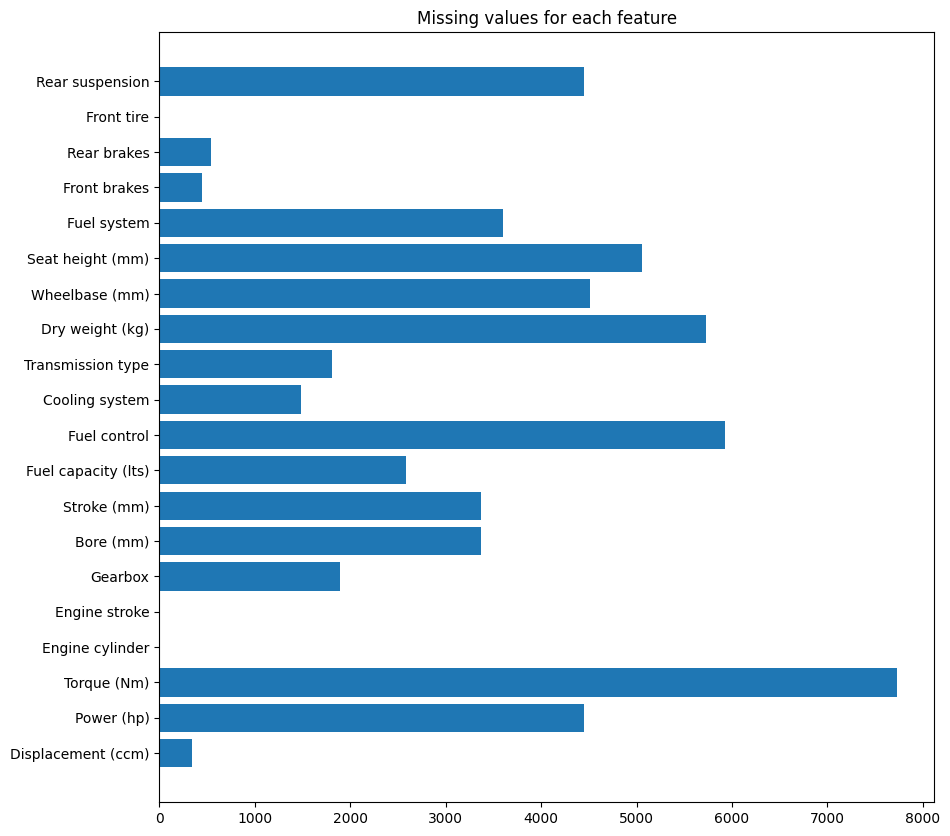

In [86]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.barh(list(missing_count.keys()), missing_count.values())
ax.set_title('Missing values for each feature')

idea:
1. togliamo le righe che hanno troppi missing values;
2. facciamo il replacement con la moda;
3. NON facciamo il replacement sulle colonne categoriche con tanti missing values;
4. Torque (Nm) ha praticamente tutti missing values, che sia da togliere direttamente dall'analisi?
    

In [87]:
missing_threshold = 11 
perc = sum(missing[missing>missing_threshold])/sum(missing)*100
workdf = workdf[missing<=missing_threshold]

print('Rows with more than', missing_threshold, 'missing values have been deleted.', f'{perc:.2f}%', 'of the data has been deleted')

#workdf.drop('Torque(Nm)') #TODO da vedere se droppare la colonna torque

missing_threshold_perc = 0.33

for col in workdf.iloc[:, 5:].columns: #for each feature column
    if workdf[col].dtype == 'O': #if it's a categorical column
        if missing_count[col]/len(workdf)>missing_threshold_perc: #if missing values are above a threshold
            workdf[col] = workdf[col].fillna(value = 'Other') #replace with a default value
        else:
            workdf[col]= workdf[col].fillna(value = min(workdf[col].mode())) #replace with the mode
    else:#if the column is numerical
        workdf[col]=workdf[col].fillna(value = workdf[col].mean()) #replace with the mean


Rows with more than 11 missing values have been deleted. 6.24% of the data has been deleted


In [77]:
#workdf['Transmission type'].fillna(value = workdf['Transmission type'].mode())
a = min(workdf['Transmission type'].mode())